<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5F"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5F/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


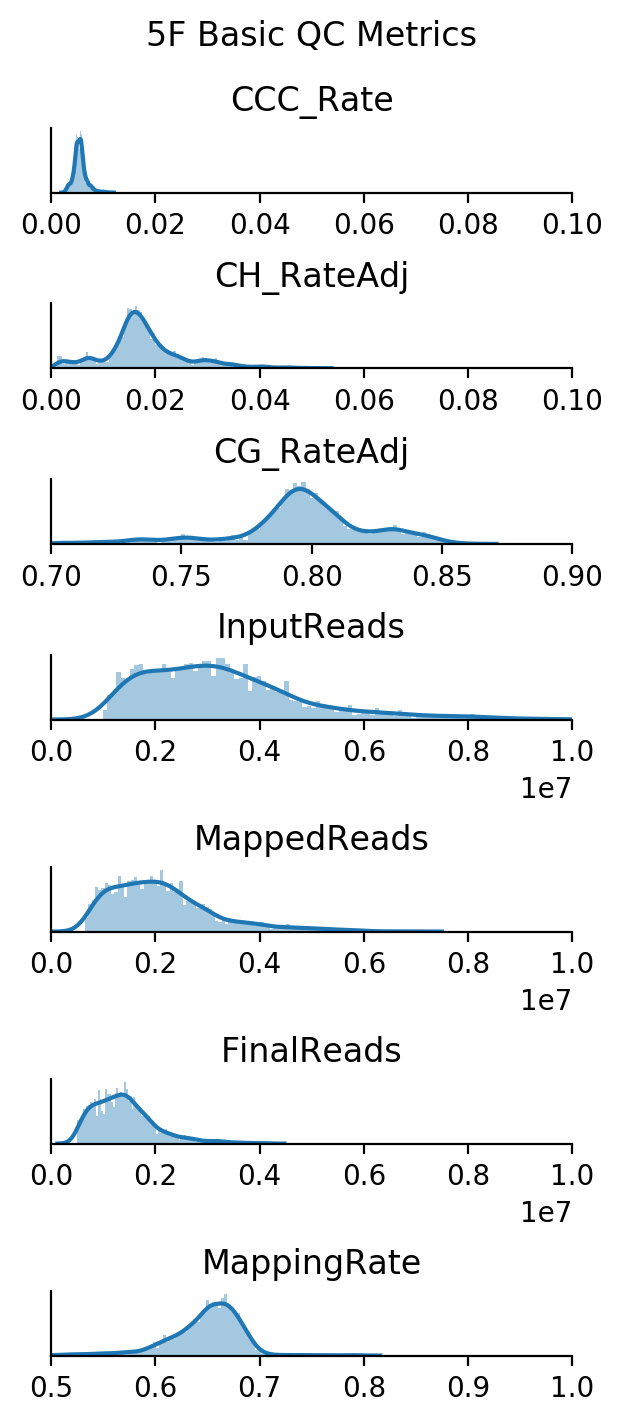

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

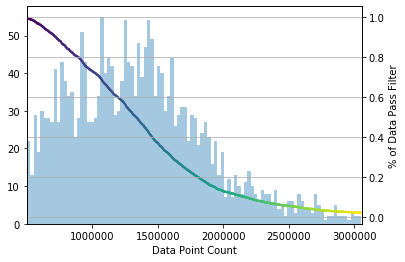

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2233/2233 (100.0%)
CG_RateAdj passed 2233/2233 (100.0%)
CH_RateAdj passed 2233/2233 (100.0%)
FinalReads passed 2233/2233 (100.0%)
MappingRate passed 2233/2233 (100.0%)
Overall passed 2233/2233 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
181218 754
181220 1479


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 246 64.1%
ad002 267 69.5%
ad004 270 70.3%
ad006 284 74.0%
ad007 303 78.9%
ad008 276 71.9%
ad010 291 75.8%
ad012 296 77.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5F_M_1,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-1...,0.004481,0.800909,0.800013,0.017156,0.012732,1037807.0,2190864,1460429.0,5F,...,6.060564,-7.911008,19.069695,36.002918,MSN-D2 Col14a1,3.205751,-1.316313,12.582277,-10.705259,True
5F_M_10,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-1...,0.005155,0.801583,0.800555,0.022887,0.017824,1900614.0,4562940,2967149.0,5F,...,7.346097,-5.480163,26.343043,21.116956,MSN-D2 Slc24a2,1.242754,-3.104940,-22.267921,-17.287911,True
5F_M_100,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-1...,0.005543,0.796197,0.795062,0.022731,0.017284,1206949.0,2986158,1728238.0,5F,...,6.360064,-5.486857,23.049544,21.356501,MSN-D2 Slc24a2,2.554324,-4.569260,-18.164735,-21.631150,True
5F_M_1000,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-3...,0.007013,0.802472,0.801077,0.030537,0.023690,1752030.0,4013734,2650715.0,5F,...,4.819915,-10.697416,13.252535,48.218942,MSN-D2 Casz1,7.142638,4.283808,36.212339,-0.487863,True
5F_M_1002,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-3...,0.005180,0.787646,0.786541,0.018573,0.013463,1065397.0,2533352,1602068.0,5F,...,3.133791,-0.850217,-19.389548,43.494621,Foxp2 Dchs2,0.234672,-2.441957,-0.238891,-6.942777,True
5F_M_1003,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-3...,0.006148,0.821175,0.820069,0.026623,0.020602,1484889.0,3377946,2268220.0,5F,...,-3.326221,-1.975166,8.249464,26.946926,PAL-Inh Meis2,11.238475,9.960647,0.219974,-26.153030,True
5F_M_1004,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-3...,0.006141,0.771433,0.770021,0.024273,0.018244,973809.0,2206910,1450565.0,5F,...,-0.059175,-17.282820,20.246259,-6.987125,D1L-Fstl4 Grm3,12.429976,-5.217456,-19.216343,-6.320786,True
5F_M_1005,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-3...,0.005094,0.803577,0.802571,0.019823,0.014805,1240319.0,2965628,1978423.0,5F,...,2.969137,-0.960478,-19.708568,45.035705,Foxp2 Dchs2,-1.322308,-3.454642,-1.845307,-12.549086,True
5F_M_1006,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-3...,0.010053,0.840848,0.839232,0.053719,0.044110,1514847.0,3759056,2505425.0,5F,...,-10.528683,2.820518,-24.684013,26.281240,PAL-Inh Chat,-1.264823,12.088564,-14.142472,34.438634,True
5F_M_1009,/gale/raidix/rdx-4/mapping/5F/CEMBA181218-5F-3...,0.006376,0.804153,0.802896,0.031438,0.025223,3393326.0,7905106,5546846.0,5F,...,-1.446616,9.104302,29.825954,-20.443541,OLF-Exc Unc13c,-0.279619,-5.940761,-0.071563,15.418739,True
